# Práctica 1 - Self-Organising Maps - COLORES
## Preparación de entorno
#### Importar librerías de código

In [1]:
# from __future__ import division

import numpy as np
import pandas as pd
import math
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from matplotlib import cm

%matplotlib inline

#### Dataset que se va a utilizar para el entrenamiento

In [2]:
# Código para obtener el Dataset que se va a usar en el entrenamiento
datos = pd.read_csv('Countries2010.csv')


## SOM Setup
#### Variables definidas por el alumno

In [3]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no
lado_mapa = 5
periodo = 20000
learning_rate = 0.15
normalizar_datos = True

#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

En este caso es necesario eliminar la columna de 'Country Name', ya que al no ser un dato numerico, no puede ser procesado por la red neuronal. Lo mantendremos en una variable para utilizarla despues del entrenamiento

In [4]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.
num_entradas = datos.shape[1] - 1
num_datos = datos.shape[0]
nombre_paises = datos['CountryName']
datos = datos.drop(['CountryName'], axis=1)
columnas = datos.columns
# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario = lado_mapa / 2

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
if normalizar_datos:
    datos = (datos - datos.min()) / (datos.max() - datos.min())
datos = datos.to_numpy()
# Crea una matriz de pesos con valores random entre 0 y 1. Usa la función random.random de la librería NumPy
matriz_pesos = np.random.random((lado_mapa, lado_mapa, num_entradas))

#### Funciones para entrenar/clasificar

In [5]:
# Función para encontrar la BMU
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
"""
# Función para encontrar la BMU
def calcular_bmu(patron_entrada, m_pesos, m):
    #Neurona mas cercana (distancia euclidea sin raiz)
    distancia_minima = math.inf
    for pos_x, fila in enumerate(m_pesos):
        for pos_y, peso in enumerate(fila):
            resultado_actual = distancia_euclidia(patron_entrada, peso, False)
            if resultado_actual < distancia_minima:
                distancia_minima = resultado_actual
                bmu = peso
                bmu_idx = np.array([pos_x, pos_y])
    return (bmu, bmu_idx)

def distancia_euclidia(matriz_a, matriz_b, incluir_raiz):
    if len(matriz_a) != len(matriz_b):
        raise Exception('La longitud de la matriz de pesos y la de componentes de un patron no coinciden')
    if incluir_raiz:
        return np.sqrt(np.sum((matriz_a - matriz_b)**2))
    return np.sum((matriz_a - matriz_b)**2)
        

In [6]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
def variacion_learning_rate(lr_inicial, i, n_iteraciones):
    learning_rate = lr_inicial * (1 - (i / n_iteraciones))
    return learning_rate

In [7]:
# Función para calcular el descenso del vecindario (v)
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
def variacion_vecindario(vecindario_inicial, i, n_iteraciones):
    lvecindario = 1 + vecindario_inicial * (1 - (i / n_iteraciones))
    return lvecindario

In [8]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    return np.exp(-distancia_BMU**2 / (2*vecindario_actual**2))

#### Funciones para dibujar la salida de la red

In [9]:
"""
    Dibuja el mapa de la matriz de pesos cambiando el color en base a 'caracteristica_objetivo'
    Entradas: (matriz_valores, iteracion, caracteristica_objetivo)
"""
def pintar_mapa(matriz_valores, iteracion, caracteristica_objetivo):
    fig = plt.figure()
    #Seleccionamos el indice de la caracteristica que nos interesa.
    #El indice coincide con el indice de la caracteristica en el dataset original
    caracteristicas = {
        'GDP_PER_CAPITA': 1,
        'MORTALITY_RATE': 5
    }
    caracteristica = caracteristicas[caracteristica_objetivo]
    # Establece ejes
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, matriz_valores.shape[0]+1))
    ax.set_ylim((0, matriz_valores.shape[1]+1))
    ax.set_title('Self-Organising Map después de %d iteraciones' % iteracion)

    # Dibuja los rectángulos de color RGB
    for x in range(1, matriz_valores.shape[0] + 1):
        for y in range(1, matriz_valores.shape[1] + 1):
            ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                         facecolor=[0, matriz_valores[x-1,y-1,caracteristica], 0],
                         edgecolor='none'))
    plt.show()
'''
Dibuja un histograma 3D del mapa de activaciones.
Entradas: (mapa_activaciones)
'''
def histograma_3d(mapa_activaciones):
    array_datos = np.array(mapa_activaciones)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    datos_x, datos_y = np.meshgrid(
            np.arange(array_datos.shape[1]),
            np.arange(array_datos.shape[0])
    )
    cmap = cm.get_cmap('jet')
    datos_x = datos_x.flatten()
    datos_y = datos_y.flatten()
    datos_z = array_datos.flatten()
    rgba = [cmap(k/max(datos_z)) for k in datos_z] 
    ax.bar3d( datos_x,
              datos_y,
              np.zeros(len(datos_z)),
              0.5, 0.5, datos_z,
            color=rgba)
    plt.show()

### Metricas del modelo
Aquí incluimos el error de cuantificación y el topológico, además de una funcion que nos permita observar rápidamente si el modelo que estamos usando es el adecuado. En este caso, buscamos si la bmu y la segunda bmu están una al lado de la otra

In [10]:
"""
    Calcula el error topologico de un elemento (funcion auxiliar)
    Entradas: (patron_entrada, m_pesos)
    Salidas: adyacente
"""
def error_adyacente(patron_entrada, m_pesos):
    distancia_minima = math.inf
    distancia_minima2 = math.inf
    bmu_id1 = np.array([0, 0])
    for pos_x, fila in enumerate(m_pesos):
        for pos_y, peso in enumerate(fila):
            resultado_actual = distancia_euclidia(patron_entrada, peso, False)
            if resultado_actual < distancia_minima:
                bmu_id2 = bmu_id1
                distancia_minima2 = distancia_minima

                distancia_minima = resultado_actual
                bmu_id1 = np.array([pos_x, pos_y])
            elif resultado_actual < distancia_minima2:
                bmu_id2 = np.array([pos_x, pos_y])
                distancia_minima2 = resultado_actual
    adyacente = not(abs(bmu_id1[0] - bmu_id2[0]) <= 1 and abs(bmu_id1[1] - bmu_id2[1]) <=1)
    return adyacente
"""
    Calcula la suma y media de todos los errores topologicos
    Entrdas: (datos_ej, m_pesos)
    Salidas: (sol)
"""
def error_topologico_total(datos_ej, m_pesos):
    sol=0
    for dato_ej in datos_ej :
        sol += error_adyacente(dato_ej, m_pesos)
    sol = sol/len(datos_ej)
    return sol

Calculamos el error de cuantificacion: La media de las distancias euclidias entre un los datos de entrada y las bmus que activan.

In [11]:
"""
    Calcula el error de cuantificacion
    Entradas: (matriz_p)
    Salidas: (datos_prueba)
"""
def error_cuantificacion(matriz_p, datos_prueba):
    suma = 0
    for e in datos_prueba:
        bmu,_ = calcular_bmu(e, matriz_p, 3)
        distancia = distancia_euclidia(bmu, e, True)
        suma += distancia
    return suma / len(datos_prueba)

In [12]:
"""
    Construye el mapa de activaciones con el nombre de cada pais
    Entradas: (matriz_p, datos_prueba)
    Salidas: (sol)
"""
def mapa_activaciones(matriz_p, datos_prueba):
    #Construimos un array de arrays de dimension lado_mapa x lado_mapa en donde
    #cada elemento es otro array para poder introducirle el nombre del pais que activa
    sol = [
        [
            [] for i in range(lado_mapa)
        ] 
        for i in range(lado_mapa)
    ]
    for index,row in datos_prueba.iterrows():
        nombre = index
        dato = row.to_numpy()
        bmu,idx = calcular_bmu(row, matriz_p, 3)
        sol[idx[0]][idx[1]].append(nombre)
    return sol

In [13]:
"""
    Encuentra el numero de clases dentro de un mapa de activaciones
    Entradas: (mapa)
    Salidas: (numero_clases, matriz_numero_clases)
"""
def encontrar_numero_clases(mapa):
    numero_clases = 0
    matriz_numero_clases = np.zeros((mapa.shape[0], mapa.shape[1]))
    #Recorremos cada neurona del mapa de activaciones. Si la neurona contiene algun
    #pais, entonces es que hay una clase en esa neurona.
    for row in range(len(mapa)):
        for col in range(len(mapa[row])):
            if len(mapa[row][col]):
                numero_clases += 1
            matriz_numero_clases[row, col] = len(mapa[row][col])
    return (numero_clases, matriz_numero_clases)

In [14]:
def evaluar_modelo(matriz_p):
    error_cuant = error_cuantificacion(matriz_p,datos)
    error_topo = error_topologico_total(datos,matriz_p)
    print(f"""
        Caracteristicas:
            Learning-rate: {learning_rate}
            Periodo: {periodo}
            Numero de neuronas: {lado_mapa * lado_mapa}
        Resultados:
            Error de cuantificacion: {error_cuant}
            Error topologico: {error_topo}
    """)

## SOM Entrenamiento

In [15]:
# Entrena la red con el dataset de entrenamiento
for i in range(periodo):
    indice = np.random.choice(datos.shape[0], 1, replace=False)  
    dato = datos[indice][0]
    vecindario_actual = variacion_vecindario(vecindario, i, periodo)
    bmu, pos_bmu = calcular_bmu(dato, matriz_pesos, 3)
    for idx_fila, fila in enumerate(matriz_pesos):
        for idx_col, peso in enumerate(fila):
            distancia_bmu = distancia_euclidia([idx_fila, idx_col], pos_bmu, True)
            if distancia_bmu < vecindario_actual:
                matriz_pesos[idx_fila, idx_col] = peso + variacion_learning_rate(learning_rate, i, periodo) * decay(distancia_bmu, vecindario_actual) * (dato - peso)
    if i % 100 == 0:
        print('Iteracion:',i)

Iteracion: 0
Iteracion: 100
Iteracion: 200
Iteracion: 300
Iteracion: 400
Iteracion: 500
Iteracion: 600
Iteracion: 700
Iteracion: 800
Iteracion: 900
Iteracion: 1000
Iteracion: 1100
Iteracion: 1200
Iteracion: 1300
Iteracion: 1400
Iteracion: 1500
Iteracion: 1600
Iteracion: 1700
Iteracion: 1800
Iteracion: 1900
Iteracion: 2000
Iteracion: 2100
Iteracion: 2200
Iteracion: 2300
Iteracion: 2400
Iteracion: 2500
Iteracion: 2600
Iteracion: 2700
Iteracion: 2800
Iteracion: 2900
Iteracion: 3000
Iteracion: 3100
Iteracion: 3200
Iteracion: 3300
Iteracion: 3400
Iteracion: 3500
Iteracion: 3600
Iteracion: 3700
Iteracion: 3800
Iteracion: 3900
Iteracion: 4000
Iteracion: 4100
Iteracion: 4200
Iteracion: 4300
Iteracion: 4400
Iteracion: 4500
Iteracion: 4600
Iteracion: 4700
Iteracion: 4800
Iteracion: 4900
Iteracion: 5000
Iteracion: 5100
Iteracion: 5200
Iteracion: 5300
Iteracion: 5400
Iteracion: 5500
Iteracion: 5600
Iteracion: 5700
Iteracion: 5800
Iteracion: 5900
Iteracion: 6000
Iteracion: 6100
Iteracion: 6200
Iter

In [16]:
evaluar_modelo(matriz_pesos)


        Caracteristicas:
            Learning-rate: 0.15
            Periodo: 20000
            Numero de neuronas: 25
        Resultados:
            Error de cuantificacion: 0.3504836277602726
            Error topologico: 0.017543859649122806
    


## Pintar mapa e histograma

Volvemos a añadirle la columna de nombres a los datos originales y lo convertimos a formato dataframe

In [17]:
datos = pd.DataFrame(datos, index=nombre_paises, columns=columnas)

A continuacion, podemos comparar los pesos del PIB per capita en cada neurona y la mortalidad

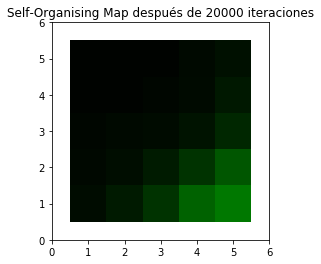

In [18]:
pintar_mapa(matriz_pesos, periodo, 'GDP_PER_CAPITA')

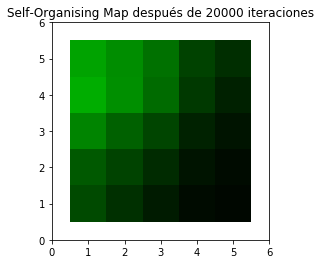

In [19]:
pintar_mapa(matriz_pesos, periodo, 'MORTALITY_RATE')

Aquí podemos ver los paises que activan la misma neurona, y vemos que tienen caracteristicas muy similares en cuanto a PIB, Mortalidad, etc.

In [20]:
mapa = mapa_activaciones(matriz_pesos, datos)
mapa

[[['Dominican Republic', 'Ecuador', 'Mongolia', 'West Bank and Gaza'],
  ['Bolivia',
   'Gabon',
   'Guatemala',
   'Honduras',
   'Iraq',
   'Nicaragua',
   'Sao Tome and Principe'],
  ['Congo, Rep.', 'Gambia, The', 'Ghana', 'Senegal'],
  ['Benin',
   'Cameroon',
   'Central African Republic',
   "Cote d'Ivoire",
   'Guinea',
   'Guinea-Bissau',
   'Haiti',
   'Liberia',
   'Mali',
   'Mauritania',
   'Nigeria',
   'Sierra Leone'],
  ['Afghanistan',
   'Burkina Faso',
   'Chad',
   'Congo, Dem. Rep.',
   'Equatorial Guinea',
   'Mozambique',
   'Niger',
   'Sudan',
   'Togo']],
 [['Brazil',
   'Colombia',
   'Iran, Islamic Rep.',
   'Jordan',
   'Mexico',
   'Peru',
   'Venezuela, RB'],
  ['Algeria', 'Cabo Verde', 'El Salvador', 'Paraguay', 'Suriname'],
  ['Botswana', 'Indonesia', 'Namibia', 'Philippines', 'South Africa'],
  ['Lao PDR', 'Lesotho', 'Pakistan', 'Swaziland', 'Zimbabwe'],
  ['Burundi',
   'Eritrea',
   'Ethiopia',
   'Kenya',
   'Madagascar',
   'Malawi',
   'Papua New Gu

Para poder dibujar un mapa con el color del PIB de cada neurona, almacenamos en cada país la neurona asociada a este. En este caso, será almacenada en 'Categoria'. Se pueden revisar las categorias descomentando la linea 'datos.to_csv('clasificacion.csv')

In [21]:
categorias = []
datos['Categoria'] = [None for i in datos.iterrows()]
iterador = 0
for i in range(len(mapa[0])):
    for j in range(len(mapa[1])):
        for elemento in mapa[i][j]:
            datos.loc[elemento, 'Categoria'] = iterador
        iterador += 1
datos['Categoria'] = datos['Categoria'].astype(int)

Descomentar la siguiente linea para ver los datos adecuadamente categorizados

In [22]:
#datos.to_csv('datos_categorizados.csv')

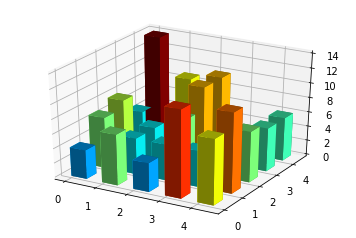

In [23]:
numero_clases, matriz_activaciones = encontrar_numero_clases(np.array(mapa))
histograma_3d(matriz_activaciones)

In [24]:
def pintar_mapa_paises(datos, numero_clases, matriz_p):
    #Descargamos la imagen de los paises
    shapename = 'admin_0_countries'
    countries_shp = shpreader.natural_earth(resolution='110m',
                                            category='cultural', name=shapename)
    
    #Escogemos los colores y el tamaño de la imagen
    colores_aux = [0, 0]
    ax = plt.axes([7, 7, 3, 3], projection=ccrs.PlateCarree())
    
    for country in shpreader.Reader(countries_shp).records():
        #Por cada pais, intentamos leer su nombre en la libreria cartopy con tres nombres diferentes,
        #ya que existen multiples formas de nombrar a los paises.
        try:
            #La categoria esta almacenada con un valor desde 0 hasta lado_mapa*lado_mapa - 1.
            #Por lo tanto, si queremos convertirlo en un valor del tipo [fila, columna], 
            #tenemos que realizar la division entera y el modulo.
            neurona = [int(datos.loc[country.attributes['NAME_SORT']]['Categoria'] // lado_mapa),
                      int(datos.loc[country.attributes['NAME_SORT']]['Categoria'] % lado_mapa)]
            rgb = np.array([colores_aux[0],
                            matriz_p[neurona[0], neurona[1], 1],
                            colores_aux[1]])
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=rgb)
        except:
            try:
                neurona = [int(datos.loc[country.attributes['NAME_LONG']]['Categoria'] // lado_mapa),
                          int(datos.loc[country.attributes['NAME_LONG']]['Categoria'] % lado_mapa)]
                rgb = np.array([colores_aux[0],
                                matriz_p[neurona[0], neurona[1], 1],
                                colores_aux[1]])
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=rgb)
            except:
                try:
                    neurona = [int(datos.loc[country.attributes['NAME']]['Categoria'] // lado_mapa),
                              int(datos.loc[country.attributes['NAME']]['Categoria'] % lado_mapa)]
                    rgb = np.array([colores_aux[0],
                                    matriz_p[neurona[0], neurona[1], 1],
                                    colores_aux[1]])
                    ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                                  facecolor=rgb)
                except:
                    pass
                pass
            pass
    ax.set_adjustable('datalim')
    plt.show()


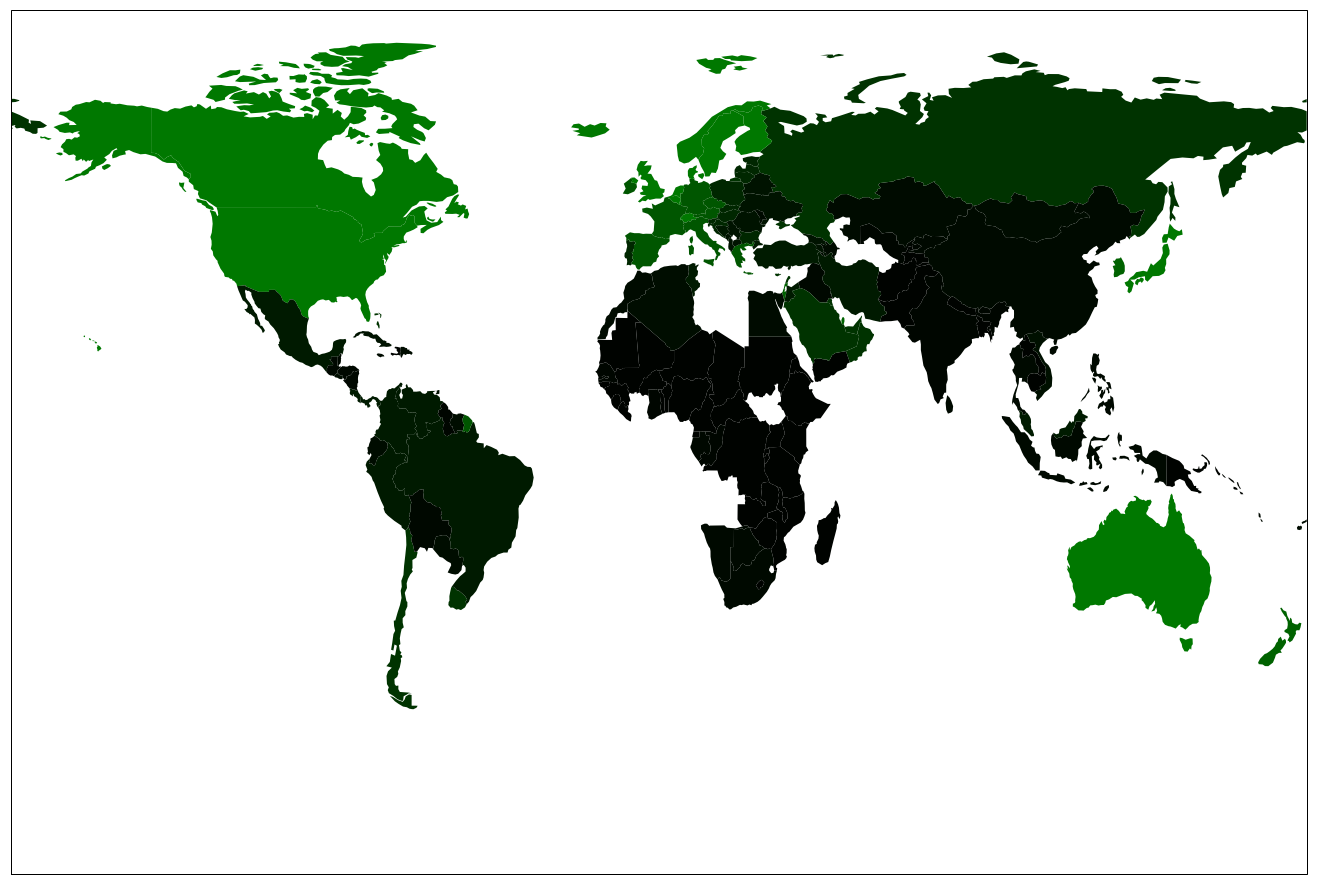

In [25]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
pintar_mapa_paises(datos, numero_clases, matriz_pesos)